In [1]:
# https://www.kaggle.com/competitions/nlp-getting-started

!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.3 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
!git clone https://github.com/berndheidemann/twitter_disaster_text_classification.git

Cloning into 'twitter_disaster_text_classification'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 7), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (22/22), 621.20 KiB | 2.60 MiB/s, done.


In [4]:
import pandas as pd

#path="./"
path="/kaggle/working/twitter_disaster_text_classification/"
train_csv=path+"train.csv"
test_csv=path+"test.csv"
submission_csv=path+"sample_submission.csv"

df = pd.read_csv(train_csv)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
len(df)

7613

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['text'])

vocab = build_vocab_from_iterator(df_iterator_content(df), specials=["<unk>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)
print(vocab_size)

3240


In [7]:
import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwitterDisasterDataset(Dataset):
    def __init__(self, df, word_count=500, vocab_size=10000, train=True):
        self.df = df
        self.word_count = word_count
        self.vocab_size = vocab_size
        self.train=train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["text"]
        x = vocab(tokenizer(x))
        if self.train:
            y= self.df.iloc[idx]["target"]
            y = int(y)
        if len(x) > self.word_count:
            x=x[:self.word_count]
        else:
            x.extend([0]*(self.word_count-len(x)))
        x = torch.tensor(x)
        if self.train:
            return x.to(device), torch.tensor(y).to(device)
        else:
            return x.to(device)

twitter_dataset = TwitterDisasterDataset(df, word_count=30, vocab_size=vocab_size)
x,y=twitter_dataset[0]
print(x.shape)
print(y)

torch.Size([30])
tensor(1, device='cuda:0')


In [8]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

class MyLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, out_size, word_count=50, dropout=0.2, num_layers=2):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim=embedding_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout, num_layers=num_layers)
        self.dropout=nn.Dropout(p=dropout)
        # The linear layer that maps from hidden state space to output space
        self.hidden2output = nn.Linear(hidden_dim*word_count, out_size)

    def forward(self, xb):
        #print("xb shape", xb.shape)
        embeds = self.word_embeddings(xb)
        #print("embeds shape", embeds.shape)
        lstm_out, _ = self.lstm(embeds)
        lstm_out=self.dropout(lstm_out)
        #print("lstm_out shape", lstm_out.shape)
        # lstm_out_view = lstm_out[:, -1, :]   # works but looses information
        lstm_out_view = lstm_out.reshape(xb.shape[0], -1   )
        #print("lstm_out_view shape", lstm_out_view.shape)
        hidden_space = self.hidden2output(lstm_out_view)
        #print("hidden_space shape", hidden_space.shape)
        output = F.log_softmax(hidden_space, dim=1)
        #print("output shape", output.shape)
        return output

In [9]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader):
    model.eval()
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predicted_label.argmax(1).cpu().numpy())
    return f1_score(y_true, y_pred)


In [10]:
# Hyperparameter
embed_dim = 128
num_class = 2
hidden_dim = 64
word_count = 30
EPOCHS = 10 # epoch
LR = 0.01  # learning rate
scheduler_patience=4
scheduler_factor=0.2
weight_decay=1e-4
BATCH_SIZE = 64 # batch size for training
dropout=0.7
num_layers=5

# check if model works
model= MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout, num_layers=num_layers).to(device)
dataset = TwitterDisasterDataset(df, word_count=word_count, vocab_size=vocab_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

xb, yb = next(iter(loader))
print("yb", yb)
print("xb", xb.shape)
model(xb)

yb tensor([1, 0, 0, 1, 0], device='cuda:0')
xb torch.Size([5, 30])


tensor([[-0.7036, -0.6828],
        [-0.7092, -0.6774],
        [-0.7734, -0.6188],
        [-0.7146, -0.6721],
        [-0.7071, -0.6794]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [11]:
# hyperparameter search
from sklearn.model_selection import ParameterGrid

param_grid = {
    "embed_dim": [64, 128],
    "hidden_dim": [64, 128],
    "dropout": [0.4, 0.7],
    "num_layers": [2, 5],
    "weight_decay": [1e-4, 1e-6],
    "LR": [0.01, 0.001],
    "BATCH_SIZE": [64, 256]
}

param_grid = ParameterGrid(param_grid)

print(next(iter(param_grid)))
print(len(param_grid))

{'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'num_layers': 2, 'weight_decay': 0.0001}
128


In [16]:
from sklearn.model_selection import StratifiedKFold
import time
from tqdm import tqdm
from torch.utils.data import DataLoader

EPOCHS=10

# set all random seeds
torch.manual_seed(1)
np.random.seed(1)

k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
(gridsearch_portion_idx, test_idx) = next(iter(k_fold.split(df["text"], df["target"])))
grid_test_df=df.iloc[test_idx]
gridsearch_df=df.iloc[gridsearch_portion_idx]
test_dataset=TwitterDisasterDataset(grid_test_df, word_count=word_count, vocab_size=vocab_size)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


k_fold_iter=iter(k_fold.split(gridsearch_df["text"], gridsearch_df["target"]))
(base_idx, split_portion_idx)=next(k_fold_iter)
base_df = df.iloc[base_idx]
split_portion_df = df.iloc[split_portion_idx]
train_dataset = TwitterDisasterDataset(split_portion_df, word_count=word_count, vocab_size=vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
i=0
best_params_val=0
best_params=None
for params in param_grid:
    i+=1
    
    model = MyLSTM(params["embed_dim"], params["hidden_dim"], vocab_size, num_class, word_count=word_count, dropout=params["dropout"], num_layers=params["num_layers"]).to(device)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params["LR"], weight_decay=params["weight_decay"])
    for epoch in range(EPOCHS):
        model.train()
        for idx, (text, label) in enumerate(train_dataloader):
            predicted_label = model(text)
            loss = loss_func(predicted_label, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    test_f1 = evaluate(model, test_dataloader)
    print(f"{i} / {len(param_grid)} params {params} Test f1 {test_f1}")
    with open("results.txt", "a") as f:
        f.write(f"{i}: params {params} test f1 {test_f1} \n")
    if test_f1 > best_params_val:
        best_params_val = test_f1
        best_params = params

1 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'num_layers': 2, 'weight_decay': 0.0001} Test f1 0.6502463054187192
2 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'num_layers': 2, 'weight_decay': 1e-06} Test f1 0.6688311688311689
3 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'num_layers': 5, 'weight_decay': 0.0001} Test f1 0.6212914485165795
4 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'num_layers': 5, 'weight_decay': 1e-06} Test f1 0.6559485530546624
5 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'weight_decay': 0.0001} Test f1 0.6220839813374804
6 / 128 params {'BATCH_SIZE': 64, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'weight_decay': 1e-06} Test f1 0.6058732612055642
7 / 128 par

In [17]:
best_params

{'BATCH_SIZE': 256,
 'LR': 0.01,
 'dropout': 0.4,
 'embed_dim': 64,
 'hidden_dim': 64,
 'num_layers': 2,
 'weight_decay': 0.0001}

In [18]:
best_params_val

0.7004341534008683

In [90]:

# create train and valid dataset
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# import torch DataLoader
from torch.utils.data import DataLoader

model = MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)   # every 10 epochs, LR is multiplied by 0.7
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)



-----------------------------------------------------------
| end of epoch   1 | time:  7.59s | train f1    0.725 | valid f1    0.666 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   2 | time:  7.35s | train f1    0.798 | valid f1    0.721 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   3 | time:  7.13s | train f1    0.841 | valid f1    0.733 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   4 | time:  7.18s | train f1    0.842 | valid f1    0.716 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   5 | time:  7.04s | train f1    0.869 | valid f1    0.713 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   6 | time:  7.53s | train f1    0.876 | valid f1    0.703 | lr: 0.01000
-----------------------------------------------------------
| end of epoch   7 | time:  7.11s | train f1    0.92

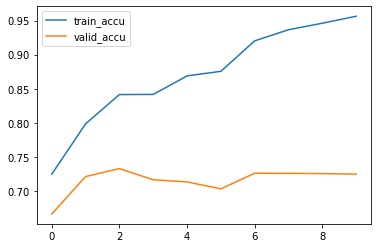

In [91]:
total_accu = None
train_accus=[]
valid_accus=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    model.train()
    total_acc, total_count = 0, 0

    for idx, (text, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = loss_func(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train f1 {:8.3f} | valid f1 {:8.3f} | lr: {:1.5f}'.format(
        epoch,
        time.time() - epoch_start_time,
        accu_train,
        accu_valid,
        #  scheduler.get_last_lr()[0]))
        optimizer.param_groups[0]['lr']))

    scheduler.step(accu_valid) # learning rate scheduler after each epoch

import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [93]:
df_test = pd.read_csv(test_csv)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [94]:
test_dataset = TwitterDisasterDataset(df_test, word_count=word_count, vocab_size=vocab_size, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predictions=[]
model.eval()
with torch.no_grad():
    for idx, (text) in enumerate(test_dataloader):
        predicted_label = model(text)
        predictions.append(predicted_label.argmax(1).cpu().numpy())
        

predictions=np.concatenate(predictions)
print(predictions.shape)

(3263,)


In [97]:
len(predictions)

3263

In [98]:
df_submission = pd.read_csv(submission_csv)
df_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [99]:
df_submission["target"] = predictions
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [100]:
df_submission.to_csv("submission.csv", index=False)

In [101]:
df_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.377567
std,3146.427221,0.484853
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
